In [1]:
import darknet
import cv2 
import deeplabcut
import numpy as np
import tempfile
import tensorflow as tf
import logging
import sys
import matplotlib.pyplot as plt
import pandas as pd

from skimage.draw import circle, line_aa, rectangle_perimeter
from deeplabcut.pose_estimation_tensorflow.nnet import predict
from deeplabcut.pose_estimation_tensorflow.nnet.net_factory import pose_net
from deeplabcut.pose_estimation_tensorflow.config import load_config
from pathlib import Path
from ruamel.yaml import YAML
from skimage.util import img_as_ubyte
from matplotlib.animation import FFMpegWriter
    
from deeplabcut.utils.video_processor import (
    VideoProcessorCV as vp,
)

yaml = YAML()

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
configPath = "/storage/gs/rat-emotion/darknet/cfg/2020-06-02_yolo-obj.cfg"
weightPath = "/storage/gs/rat-emotion/darknet/weights/2020-06-07/2020-06-02_yolo-obj_last.weights"
video = "/storage/gs/rat-emotion/videos/24fps/rat8-control1.mp4"
metaPath = "/storage/gs/rat-emotion/darknet/labeled_data/2020-06-07/obj.data"

In [3]:
class URL(str):
    def __truediv__(str, value):
        return URL(str + '/' + value)
    
project_path = URL('gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09')
config_path = project_path / 'config.yaml'
train_dir = project_path / 'dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/train' 
test_dir = project_path / 'dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/test' 
snapshot = 'snapshot-78000'

batch_size = 1

fname = video
outputname = 'test.mp4'

In [18]:
draw = True
clipping = True
setup_logger = False

In [4]:
if setup_logger:
    logging.basicConfig(level=logging.INFO, stream=sys.stdout)
    logging.info('Logging started')

s = None
logging.info('Loading darknet model')
net = darknet.load_net_custom(configPath.encode("ascii"), weightPath.encode("ascii"), 0, 1)
meta = darknet.load_meta(metaPath.encode("ascii"))
net_width, net_height = (darknet.network_width(net), darknet.network_height(net))

In [19]:
logging.info(f'Opening video {video}')
cap = cv2.VideoCapture(video)
tempdir = tempfile.TemporaryDirectory()
tempdir_path = Path(tempdir.name)
clip = vp(fname=video, sname=outputname, codec="mp4v")

n_frames = clip.nframes

scorer = 'dlc-darknet'
try:
    logging.info('Downloading DLC model')
    ! gsutil cp {train_dir / snapshot + '*'} {tempdir.name}
    ! gsutil cp {project_path / 'config.yaml'} {tempdir.name}
    ! gsutil cp {test_dir / 'pose_cfg.yaml'} {tempdir.name}
    
    logging.info('Load config')
    with open(tempdir_path / 'config.yaml', 'r') as fp:
        cfg = yaml.load(fp)
        
    nx = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    ny = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    cap.release()
    colorclass = plt.cm.ScalarMappable(cmap=cfg["colormap"])
    C = colorclass.to_rgba(np.linspace(0, 1, len(cfg['bodyparts'])))
    colors = (C[:, :3] * 255).astype(np.uint8)

    dlc_cfg = load_config(tempdir_path / 'pose_cfg.yaml')
    dlc_cfg['init_weights'] = str(tempdir_path / snapshot)
    dlc_cfg["num_outputs"] = cfg.get("num_outputs", dlc_cfg.get("num_outputs", 1))
    dlc_cfg["batch_size"] = batch_size
    cfg["batch_size"] = batch_size
    
    df_index = pd.MultiIndex.from_product(
        [
            [scorer],
            dlc_cfg['all_joints_names'],
            ['x', 'y', 'likelihood']
        ], names=['scorer', 'bodyparts', 'coords']
    )
    df = pd.DataFrame(columns=df_index)
        
    logging.info('Create DLC session')
    sess, inputs, outputs = predict.setup_GPUpose_prediction(dlc_cfg)
    
    dpi = 100
    fig = plt.figure(frameon=False, figsize=(nx / dpi, ny / dpi))
    ax = fig.add_subplot(111)
    
    logging.info('Processing video')
    for frame_idx in range(n_frames):
        if not setup_logger and frame_idx % 500 == 0:
            print(f'Processing frame {frame_idx}')
            
        try:
            x0 = 0
            y0 = 0
            
            logging.info(f'Reading frame {frame_idx}')
            frame = clip.load_frame()

            logging.info('Loading frame')
            im, arr = darknet.array_to_image(frame)

            logging.info('Finding boundary box')
            res = darknet.detect_image(net, meta, im, thresh=.5, hier_thresh=.5, nms=.45, debug= False)
            cutframe = frame.copy()           
            if res and clipping:
                name, confidence, (x, y, w, h) = res[0]
                if confidence > 0.7 and min([w, h]) > 100:
                    x0, y0 = int(x - w/2), int(y - h/2)
                    x1, y1 = int(x + w/2), int(y + h/2)
                    cutframe = cutframe[y0:y1, x0:x1]
                    if draw:
                        rr, cc = rectangle_perimeter((y0,x0), (y1,x1))
                        frame[rr, cc] = colors[0]
                    logging.info('Frame cut to fit boundary box')
                else:
                    logging.info('Boundary box ignored due to low confidence')
            else:
                logging.info('No boundary box found')

            logging.info('Finding pose')
            ubyte_image = img_as_ubyte(cutframe)
            im = np.expand_dims(ubyte_image, axis=0).astype(float)
            outputs_np = sess.run(outputs, feed_dict={inputs: im})

            logging.info('Saving pose')
            s = pd.Series(index=df_index, name=frame_idx)
            for i in range(outputs_np[0].shape[0]):
                y, x, c = outputs_np[0][i]
                bodypart = cfg['bodyparts'][i]

                # Account for the cropped frame
                y += y0
                x += x0

                s[scorer, bodypart, 'x'] = x
                s[scorer, bodypart, 'y'] = y
                s[scorer, bodypart, 'likelihood'] = c

                if c > cfg['pcutoff'] and draw:
                    rr, cc = circle(y, x, cfg['dotsize'], shape=(ny, nx))
                    frame[rr, cc] = colors[i]

            if draw:
                clip.save_frame(frame)
                
            df = df.append(s)  
        except Exception as e:
            logging.error('Error processing frame, skipping. Full error:\n' + str(e))
finally: 
    tempdir.cleanup()
    
    # Clear the session
    tf.keras.backend.clear_session()
    
    if draw:
        clip.close()

ERROR:root:Error processing frame, skipping. Full error:
2 root error(s) found.
  (0) Invalid argument: Reduction axis 0 is empty in shape [0,2080]
	 [[node ArgMax (defined at /root/miniconda/envs/darknet/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[ArgMax/_555]]
  (1) Invalid argument: Reduction axis 0 is empty in shape [0,2080]
	 [[node ArgMax (defined at /root/miniconda/envs/darknet/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'ArgMax':
  File "/root/miniconda/envs/darknet/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/root/miniconda/envs/darknet/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/miniconda/envs/darknet/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/root/miniconda/envs/darknet/l

# Save Data

In [20]:
df.to_hdf("ra8-control1_with-yolo.h5", "df_with_missing", format="table", mode="w")

In [21]:
cap.release()

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/root/miniconda/envs/darknet/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


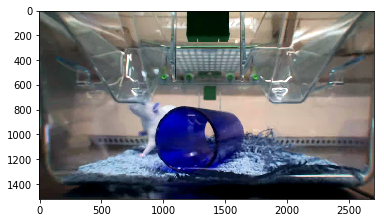

In [6]:
%matplotlib inline
plt.imshow(frame)

In [7]:
ls

core  darknet-dlc.ipynb  darknet-python.ipynb  gsutil-examples.ipynb  test.mp4


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


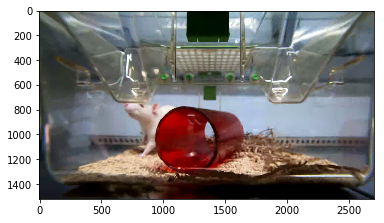

In [15]:
%matplotlib inline
ret, frame = cap.read()
plt.imshow(frame)

In [16]:
df

scorer     dlc-darknet                                                   \
bodyparts         nose                            left-ear                
coords               x           y likelihood            x            y   
0          1943.501221  263.109406   0.580100  1207.555664   607.737793   
1           226.814240  656.204712   0.729719  2700.019043  1281.501343   
2          1947.137085  259.086029   0.621254  1832.292236   564.014465   
3          1949.043579  261.425751   0.586604   760.875000   608.726501   

scorer                                                                 ...  \
bodyparts               right-ear                        left-eye-top  ...   
coords    likelihood            x           y likelihood            x  ...   
0           0.673845  1203.343262  606.338257   0.869484   451.017059  ...   
1           0.249037    85.098961  860.796814   0.517875   450.932617  ...   
2           0.189257    85.991928  853.099854   0.872561   942.663757  ...   
3           0.169851   760.233704  608.447815   0.773437   484.322174  ...   

scorer                                                                        \
bodyparts left-rear-paw right-rear-paw                        left-front-paw   
coords       likelihood              x           y likelihood              x   
0              0.007970    1949.576782  268.953674   0.006214      80.709000   
1              0.010713     226.015930  662.299927   0.009866     226.253540   
2              0.007681      90.937958  860.139038   0.009230      83.347870   
3              0.009689      93.204369  861.844360   0.007523      84.645821   

scorer                                                                   
bodyparts                        right-front-paw                         
coords              y likelihood               x           y likelihood  
0          865.375671   0.282462       84.167603  869.156372   0.217312  
1          658.712952   0.293928      226.629349  661.880981   0.246444  
2          856.041565   0.108668       89.021255  860.112061   0.091670  
3          857.259155   0.155624       90.052551  861.076843   0.153724  

[4 rows x 48 columns]

In [17]:
import os

cfg['bodyparts']

['nose', 'left-ear', 'right-ear', 'left-eye-top', 'left-eye-bottom', 'left-eye-front', 'left-eye-back', 'right-eye-top', 'right-eye-bottom', 'right-eye-front', 'right-eye-back', 'tail-base', 'left-rear-paw', 'right-rear-paw', 'left-front-paw', 'right-front-paw']

In [11]:
df.to_hdf('test.h5')

TypeError: to_hdf() missing 1 required positional argument: 'key'

In [13]:
s

scorer       bodyparts         coords    
dlc-darknet  nose              x             939.353579
                               y             859.344772
                               likelihood      0.196627
             left-ear          x             978.665161
                               y             684.240976
                               likelihood      0.289336
             right-ear         x             933.272869
                               y             859.036758
                               likelihood      0.252425
             left-eye-top      x             917.388648
                               y             859.445877
                               likelihood      0.035457
             left-eye-bottom   x             938.704533
                               y             873.965607
                               likelihood      0.044214
             left-eye-front    x             922.662363
                               y             860.340988
      

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


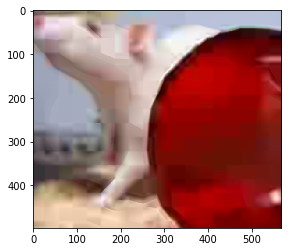

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(cutframe)